In [ ]:
import cv2 as cv
import numpy as np
import time
import os
import imutils
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist

In [ ]:
WHITE = (255,255,255)
img = None
img0 = None
outputs = None
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
# iou is technique used in non-maximal suppression to compare how close two different bounding baxes are
IOU_THRESHOLD = 0.5

#the neural network configuration
config_path = "cfg/yolov3.cfg"
#the yolo net weights file
weights_path = "weights/yolov3.weights"

In [ ]:
#loading all class labels
classes = open('data/coco.names').read().strip().split('\n')
np.random.seed(42)
#generating colors for each object
colors = np.random.randint(0,255,size=(len(classes), 3), dtype='uint8')

In [ ]:
#load the yolo network
net = cv.dnn.readNetFromDarknet(config_path, weights_path)
# net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

#get all layers name
ln = net.getLayerNames()
print(ln)
ln = [ln[i[0] -1] for i in net.getUnconnectedOutLayers()]

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

#we will first try yolo object detection in images and we will try it in videos.




In [ ]:
def post_process(img, outputs, conf):
    H, W = img.shape[:2]

    boxes = []
    confidences = []
    classIDs = []

    for output in outputs:
        for detection in output:
            #extract the class id (label) and confidence (as a probability) of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            # discard out weak predictions
            if confidence > conf:
                box = detection[:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                # p0 = int(x - w//2), int(y - h//2)
                # p1 = int(x + w//2), int(y + h//2)
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    
    #performing the non maximum suppression
    indices = cv.dnn.NMSBoxes(boxes, confidences, conf, conf - 0.1)
    #at least one is detected
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in colors[classIDs[i]]]
            cv.rectangle(img, (x,y), (x+w, y+h), color, 2)
            text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
            (text_width, text_height) = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 1, 1)[0]
            text_offset_x = x
            text_offset_y = y - 5
            box_cords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
            overlay = img.copy()
            cv.rectangle(img, box_cords[0], box_cords[1], color = color, thickness = cv.FILLED)
            cv.putText(img, text, (x,y-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 1)


In [ ]:
def load_image(path):
    global img, img0, outputs, ln
    #read the image
    img0 = cv.imread(path)
    img = img0.copy()
    # split filename and its extension for later use in naming output file
    file_name = os.path.basename(path)
    filename, ext = file_name.split(".")
    # create 4d blob from opencv
    blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB = True, crop = False)
    net.setInput(blob)
    t0 = time.time()
    #feed forward
    outputs = net.forward(ln)
    t = time.time() - t0
    print(f"time took: {t:.3f}s")
    post_process(img, outputs, CONFIDENCE)
    cv2_imshow(img)
    cv.imwrite(f"images/{filename}_out.{ext}", img)

time took: 2.414s


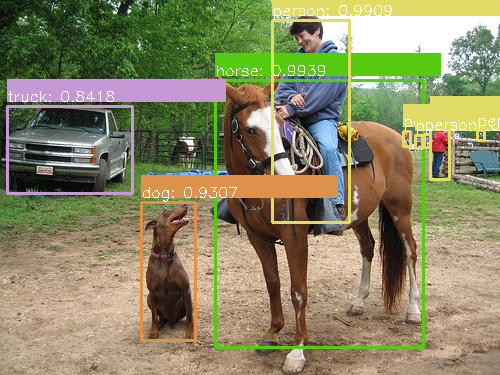

In [ ]:
load_image('images/horse.jpg')

#NOW LETS TRY THIS FOR VIDEO AND DETECT DISTANCE BETWEEN PEOPLES!!

we can change little in above functions but i am going to create it again

In [ ]:
MIN_DISTANCE = 50
def detect_people(frame, personIDX=0):
    (H, W) = frame.shape[:2]
    results = []
    blob = cv.dnn.blobFromImage(frame, 1/255.0 , (416, 416), swapRB = True, crop = False)
    net.setInput(blob)
    layersOutputs = net.forward(ln)

    boxes = []
    centroids = []
    confidences = []

    for output in layersOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if classID == personIDX and confidence > CONFIDENCE:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                centroids.append((centerX, centerY))
                confidences.append(float(confidence))

    idx = cv.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, IOU_THRESHOLD)

    if len(idx) > 0:
        for i in idx.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            r = (confidences[i], (x,y,x+w,y+h), centroids[i])
            results.append(r)
    
    return results

In [ ]:
def create_video(video):
    vid = cv.VideoCapture(video)
    writer = None

    while True:
        (grabbed, frame) = vid.read()
        if not grabbed:
            break
        
        frame = imutils.resize(frame, width = 700)
        results = detect_people(frame, classes.index("person"))

        violate = set()
        # at least two people is required to calculate the distance between them
        if len(results) >= 2:
            centroids = np.array([r[2] for r in results])
            distance = dist.cdist(centroids, centroids, metric="euclidean")

            for i in range(0, distance.shape[1]):
                for j in range(i+1, distance.shape[1]):
                    if distance[i,j] < MIN_DISTANCE:
                        violate.add(i)
                        violate.add(j)
        
        for (i, (prob, bbox, centroid)) in enumerate(results):
            (startX, startY, endX, endY) = bbox
            height_half = (endY - startY)//2
            width_half = (endX - startX)//2 + 30
            (cX, cY) = centroid
            color = (0, 255, 0)

            if i in violate:
                color = (0,0,255)
            cv.circle(frame, (cX - 20, cY + height_half), width_half, color, 2)
            cv.circle(frame, (cX, cY), 5, color, 1)
        text = f"Violating N.O : {len(violate)}"
        cv.putText(frame, text, (10, frame.shape[0] - 25), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0,45,225), 3)
        if writer is None:
            fourcc = cv.VideoWriter_fourcc(*"MJPG")
            writer = cv.VideoWriter("videos/output.mp4", fourcc, 25, (frame.shape[1], frame.shape[0]), True)
        if writer is not None:
            writer.write(frame)

In [ ]:
create_video("videos/backgroundvideo_people_walking.mp4")